# Pre-processing and Modeling

In [1]:
import pathlib
import sys

import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as t
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from comet_ml import Experiment

#import utilities
sys.path.append('src/')
import utils as utils

In [3]:
#define training and save paths and read in training csv and label key
train_dir = 'gwhd_2021/images/'

In [4]:
# Import the data
metadata = pd.read_csv('gwhd_2021/metadata_dataset.csv', sep=';')
# Update metadata['name'] to metadata['domain'] to match full column name
metadata.rename(columns = {"name": "domain"}, inplace=True)

In [5]:
train = pd.read_csv('gwhd_2021/competition_train.csv')

In [6]:
train_df = train.merge(metadata, on='domain')

In [7]:
train_df = utils.preprocess_df(train_df)

In [8]:
train_df.head()

,image_name,BoxesString,domain,country,location,development_stage,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax
0,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[99, 692, 160, 764]",Arvalis_1,France,Gréoux,Post-flowering,99.0,692.0,160.0,764.0
1,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[641, 27, 697, 115]",Arvalis_1,France,Gréoux,Post-flowering,641.0,27.0,697.0,115.0
2,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[935, 978, 1012, 1020]",Arvalis_1,France,Gréoux,Post-flowering,935.0,978.0,1012.0,1020.0
3,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[377, 834, 463, 890]",Arvalis_1,France,Gréoux,Post-flowering,377.0,834.0,463.0,890.0
4,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[654, 797, 696, 837]",Arvalis_1,France,Gréoux,Post-flowering,654.0,797.0,696.0,837.0


First off, let's address the class imbalances of development stage. 

## Balancing class distribution

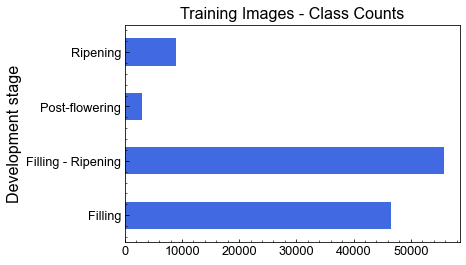

In [9]:
utils.set_plot(16)
train_df.groupby('development_stage').count().plot.barh(title='Training Images - Class Counts', 
                                                        legend=False, color='royalblue', 
                                                        xlabel="Development stage")
plt.show()

In [10]:
# To use the balanced_df function, we will need a numeric label representation
label_dict = {'Ripening': 0, 'Post-flowering': 1, 'Filling - Ripening': 2, 'Filling': 3}

train_df['label'] = train_df['development_stage'].copy()
train_df['label'].replace(label_dict, inplace=True)

In [11]:
train_df

,image_name,BoxesString,domain,country,location,development_stage,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,label
0,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[99, 692, 160, 764]",Arvalis_1,France,Gréoux,Post-flowering,99.0,692.0,160.0,764.0,1
1,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[641, 27, 697, 115]",Arvalis_1,France,Gréoux,Post-flowering,641.0,27.0,697.0,115.0,1
2,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[935, 978, 1012, 1020]",Arvalis_1,France,Gréoux,Post-flowering,935.0,978.0,1012.0,1020.0,1
3,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[377, 834, 463, 890]",Arvalis_1,France,Gréoux,Post-flowering,377.0,834.0,463.0,890.0,1
4,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[654, 797, 696, 837]",Arvalis_1,France,Gréoux,Post-flowering,654.0,797.0,696.0,837.0,1
...,...,...,...,...,...,...,...,...,...,...,...
114132,de85de89b3969fc6eb97d0c83299ad725a52595bde4533...,"[640, 1000, 700, 1024]",ULiège-GxABT_1,Belgium,Gembloux,Ripening,640.0,1000.0,700.0,1024.0,0
114133,de85de89b3969fc6eb97d0c83299ad725a52595bde4533...,"[365, 988, 450, 1024]",ULiège-GxABT_1,Belgium,Gembloux,Ripening,365.0,988.0,450.0,1024.0,0
114134,de85de89b3969fc6eb97d0c83299ad725a52595bde4533...,"[534, 982, 635, 1023]",ULiège-GxABT_1,Belgium,Gembloux,Ripening,534.0,982.0,635.0,1023.0,0
114135,de85de89b3969fc6eb97d0c83299ad725a52595bde4533...,"[608, 921, 820, 999]",ULiège-GxABT_1,Belgium,Gembloux,Ripening,608.0,921.0,820.0,999.0,0


In [12]:
# The data is clearly quite imbalanced. 
# We will want to resample the data to have balanced classes.
balanced_df = utils.balance_df(train_df, class_size=10000)

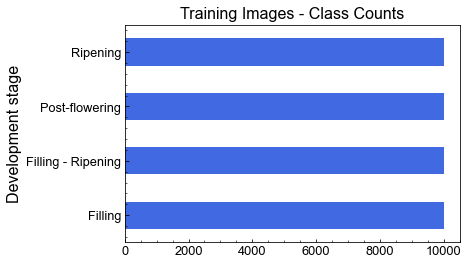

In [13]:
balanced_df.groupby('development_stage').count().plot.barh(title='Training Images - Class Counts', 
                                                        legend=False, color='royalblue', 
                                                        xlabel="Development stage")
plt.show()

#### TO-DO:
* Scale images down
* Build baseline model for comparison later


The images are currently all 1024 x 1024. Let's rescale them to 256 x 256.

In [14]:
balanced_df.rename(columns = {"image_name": "image_id"}, inplace=True)

In [28]:
balanced_df.head()

,old_index,image_id,BoxesString,domain,country,location,development_stage,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,label,class
0,444,82b3f5da5af875fe376c9fe5a408e2039a8dc3e237870b...,"[308, 303, 347, 342]",Arvalis_1,France,Gréoux,Post-flowering,308.0,303.0,347.0,342.0,1,Post-flowering
1,2034,ecfbd7c799c46d83ec798950feec64804658c37ca456e4...,"[209, 175, 347, 216]",Arvalis_1,France,Gréoux,Post-flowering,209.0,175.0,347.0,216.0,1,Post-flowering
2,26914,b1e23081cd1269310dbcaefd3a5873aae595750c209237...,"[732, 565, 835, 647]",Arvalis_3,France,Gréoux,Filling - Ripening,732.0,565.0,835.0,647.0,2,Filling - Ripening
3,82264,0469b1f61f7226cbe009dc95468144fa7079463063643e...,"[149, 359, 194, 389]",NMBU_1,Norway,NMBU,Filling,149.0,359.0,194.0,389.0,3,Filling
4,85289,7a2f24e4de0addfcc7dad6474f7a95aad80a8f54047f71...,"[712, 371, 764, 439]",NMBU_1,Norway,NMBU,Filling,712.0,371.0,764.0,439.0,3,Filling


In [15]:
# balanced_df.to_csv('transformed_data/balanced_df.csv')

In [16]:
from preprocessing2 import *

In [18]:
label_key = {0 : 'Ripening', 1 : 'Post-flowering', 2 : 'Filling - Ripening', 3 : 'Filling'}

In [20]:
#instantiate the ImageFromDFLoader class
dl = ImageFromDFLoader(balanced_df, label_key, train_dir)

Found 34000 validated image filenames belonging to 4 classes.
Found 6000 validated image filenames belonging to 4 classes.
Found 6000 validated image filenames belonging to 4 classes.


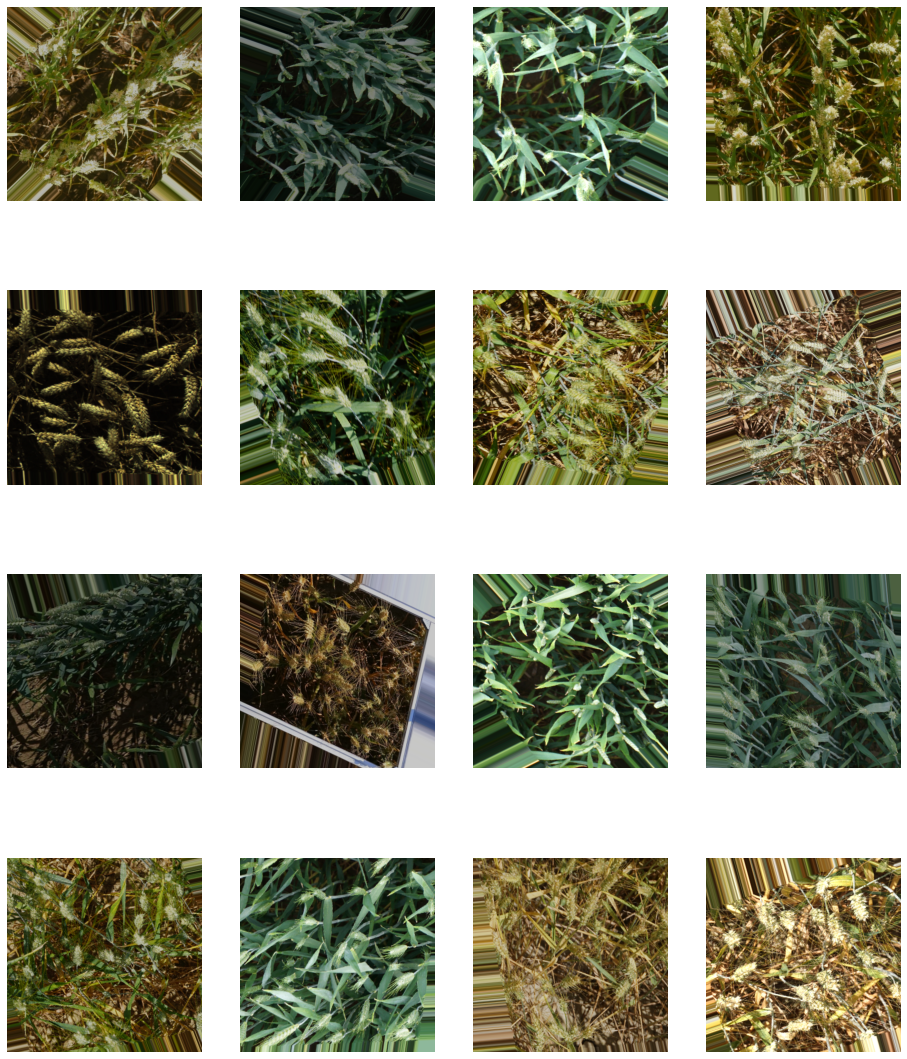

In [21]:
dl.plot_train_batch()

In [27]:
model = t.keras.applications.efficientnet.EfficientNetB4()
model.freeze_up_to_block('3')
model.compile_model()

AttributeError: 'Functional' object has no attribute 'freeze_up_to_block'

In [25]:
model = t.keras.applications.efficientnet.EfficientNetB4(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

2022-03-31 21:41:38.793593: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


78880768/78864416 [==============================] - 2s 0us/step


In [ ]:
#define training and save paths and read in training csv and label key
train_dir = '/content/cassava/data/train_images/'
df = pd.read_csv('/content/cassava/data/train.csv')
label_key = pd.read_json('/content/cassava/data/label_num_to_disease_map.json', typ='series')
save_dir = '/gdrive/MyDrive/colab_projects/cassava/models/'